In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
from annoy import AnnoyIndex
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-query-product-search/query_150k.csv
/kaggle/input/amazon-query-product-search/product_150k.csv
/kaggle/input/amazon-query-product-search/shopping_queries_dataset_products.parquet
/kaggle/input/amazon-query-product-search/dataset_350k.csv
/kaggle/input/amazon-query-product-search/shopping_queries_dataset_sources.csv
/kaggle/input/amazon-query-product-search/dataset_150k.csv
/kaggle/input/amazon-query-product-search/shopping_queries_dataset_examples.parquet
/kaggle/input/amazon-query-product-search/Dataset.csv
/kaggle/input/amazon-query-product-search/Images/two-tower-model-architecture.png
/kaggle/input/amazon-query-product-search/Images/two-tower-model-architecture-implemented.png


In [25]:
df_product_embedding = pd.merge(
    pd.read_csv('/kaggle/input/amazon-query-product-search/product_150k.csv'),
    pd.read_parquet('/kaggle/input/amazon-query-product-search/shopping_queries_dataset_products.parquet')[['product_id','product_title']].drop_duplicates(),
    on = ['product_id']
).reset_index(drop=True)

df_product_embedding['pid'] = range(0, df_product_embedding.shape[0])

df_query_embedding = pd.read_csv('/kaggle/input/amazon-query-product-search/query_150k.csv')
df_query_embedding['qid'] = range(0, df_query_embedding.shape[0])

In [26]:
df_query_embedding.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q24,q25,q26,q27,q28,q29,q30,q31,query,qid
0,0.016756,-0.072765,0.010259,0.048307,0.074665,0.084850,0.022835,-0.066671,0.039883,-0.027148,...,0.011363,0.015675,0.018649,0.025668,0.000701,-0.006060,-0.078536,-0.026082,child proof cabinet locks,0
1,-0.007341,-0.010955,0.059960,0.071282,0.022258,0.032136,0.042009,-0.041242,-0.009459,-0.017514,...,-0.014555,-0.002024,0.062305,0.020665,-0.005689,0.032699,-0.045051,-0.096923,ankle stockings for women sheer,1
2,0.027613,0.019582,-0.032154,0.018755,0.037383,-0.025616,0.024898,-0.025434,-0.047236,0.022970,...,-0.007898,-0.011111,0.059078,0.020216,0.017000,-0.034270,-0.007410,-0.026015,gluten free snacks,2
3,0.021799,-0.018171,0.005133,0.049379,0.021239,-0.004974,0.022700,-0.024240,-0.014328,0.018335,...,0.003084,-0.041141,0.033879,-0.002729,-0.015864,0.026388,-0.021622,-0.083685,hair geow,3
4,0.036940,-0.077912,-0.036468,0.036546,0.121124,0.009458,0.050458,-0.060216,-0.033329,-0.018182,...,0.049342,0.031401,0.065255,0.086359,-0.056535,-0.013196,-0.023676,-0.070366,"1 by one, amplified, outdoor hdtv antenna",4


In [27]:
df_product_embedding.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p153,p154,p155,p156,p157,p158,p159,product_id,product_title,pid
0,0.057728,0.011255,-0.023404,0.092429,-0.020029,0.018735,0.003974,0.008556,-0.005657,0.016547,...,0.006825,0.076608,-0.019186,-0.010564,0.000239,-0.043817,-0.097729,B01A5DU2TA,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler",0
1,0.038126,0.004931,-0.022067,0.066682,0.009379,0.017764,0.019343,0.039371,0.001445,0.010448,...,0.021710,0.093479,-0.026546,-0.052332,0.004328,-0.019683,-0.112607,B07346RPKN,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child",1
2,0.036354,0.016651,0.012105,0.096476,0.024649,-0.013194,0.018663,0.024827,-0.021811,-0.019258,...,0.026384,0.075618,0.015224,-0.049442,0.055570,-0.058420,-0.071863,B078TCVZ4V,Outee Rubber Kids Rain Boots,2
3,0.046325,0.016477,-0.022943,0.018492,-0.025954,-0.005175,0.018342,0.041428,-0.006838,-0.008621,...,0.021611,0.051968,-0.002022,-0.055210,0.022411,-0.055057,-0.084781,B07BR3PPDR,Hope & Henry Girls' Red Milano Stitch Cardigan,3
4,0.042861,-0.012059,-0.051115,0.127641,0.026230,0.011335,0.004991,0.008443,0.037345,-0.019857,...,0.021611,0.051968,-0.002022,-0.055210,0.022411,-0.055057,-0.084781,B07H5C4P19,Spring&Gege Youth Solid Full Zipper Hoodies Soft Kids Hooded Sweatshirt for Boys and Girls Size 3-4 Years Red,4


In [28]:
print(df_query_embedding.shape, df_product_embedding.shape)

(70756, 34) (147673, 163)


In [29]:
query_tower_input_dim = 32
product_tower_input_dim = (32*5)

query_tower_input_dim, product_tower_input_dim

(32, 160)

In [30]:
q = AnnoyIndex(query_tower_input_dim, 'euclidean')
mp_query_dict = {}

for ix,row in df_query_embedding.iterrows():
    mp_query_dict[row['qid']] = row['query']
    
    key = int(row['qid'])
    vec = list(row[['q'+str(x) for x in list(range(query_tower_input_dim))]])
    q.add_item(key,vec)

In [31]:
q.build(100) 
q.save('query.tree')
q = AnnoyIndex(query_tower_input_dim,  'euclidean')
q.load('query.tree')

True

In [32]:
top_k = 20
mat = []
for ix,row in df_query_embedding.iterrows():
    item = row['query']
    mat.append([item] + [mp_query_dict[x] for x in q.get_nns_by_item(row['qid'], top_k+1)[1:]])
    
    if ix == 50:
        break
    
cols = ['query_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors1 = pd.DataFrame(mat, columns = cols)

display(df_neighbors1.head(50))

['query_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,query_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,child proof cabinet locks,child locks for cabinets,cabinet locks,cabinet handles,magnetic child safety cabinet locks,lockable tool bag,ring cleaning pen,kids safety locks for cabinets,latch hook kits,electromagnetic door lock,...,surelock luggage lock,infant floor pad,baby safety locks for cabinets,baby proofing cabinet lock bows,cabinet lock,childrens kitchen set,door child lock,kitchen sink hose attachment,gingham door mat,shower garden hose wand
1,ankle stockings for women sheer,cargo pants for men,short cowboy booties for women,pants for women,dress boots for men,waist chains for women,pencil skirts for women,socks long for women,work boots for men,striped panties for women,...,underwear for men,dropcloths,cargo pants for women,back slit shirts for women,striped dresses for women,slippers for men,socks for booties women,skirts for women,tan skirts for women,dress socks for men
2,gluten free snacks,gluten free lemon cookie,heartland gluten free pasta,vegan jerky,gluten free bread,cereals sugar free,beneful wet dog food,chewy granola bars,lays hot pickle,pickled food,...,chocolate covered raisins,smart tart,wrinkle reducing cream,jerky without sugar,gluten free stuffing mix,beef jerky,miltons gluten free crackers,yung gravy,bleaching cream,peppermint tea bags
3,hair geow,arhletic sweatshirts,pink earrinfs,snoogle,mypillow sheets,sheepjes yarn,dr browns bottles,furinno,ziploc,dr browns nipples,...,craycort,gillie suit,calligrpahy,crocs,maraschino cherries,lacross boots men rubber,kill suit gillie,blue wif,timberlans,flairpens
4,"1 by one, amplified, outdoor hdtv antenna",lego 14 years and up,1/3 amber mist bottles without fist mist sprayers,1 ear wired headphones without mic,lume deodoant for private parts,1.25 drain popper without overflow,over the ear headphones charging dock,bar set without shaker,know it all wine,stand for headphones,...,unplugged wedding sign,now or laters candy,"laser, self-leveling, 3-beam",(hearing aid not amplifer),wired noise cancelling headphones without deep bass,clinique happy for men,deodorant for men gel,1$xrphone cases,cheap vinyl records under 15 dollars,c9 red and white christmas lights
5,adidas sweats slim,fila sweatpants,galaxy adidas shoes men,adidas pants men slim,adidas soccer cleats black,adidas pants men,adidas soccer cleats,adidas superstar all white,adidas beanie,adidas pants,...,adidas sweatband,mens russell sweatpants,adidas running shoes mens,billie eilish hoodie,adidas shoes men,running jacket women adidas,adidas original superstar women,adidas mens shoes samba,adidas pants women,neck warmer adidas
6,beta sitosterol now,help the beatles mps,hempcrete,liw hisyamine probiotic,zervos,dr dans cortibalm lip balm,amzcool,crystal bags to hold crystals,graco modes to grow,altavoz jbl,...,cool wallet gocci collors,didlo vibarator sex,credit card tool wallet multitool,lansinoh therapearl 3-in-1 hot or cold breast therapy pack,bathing suit surong women,testalize,zometool,kiss i gloo,duplo,methlypro
7,iphone 11 pro,ipad pro 11,ipad pro,screen protector iphone 8,apple ipad pro 11,apple iphone 11 pro unlocked,screen protector iphone 6s,iphone 11 accessories,ipad pro screen protector 11,screen protector iphone x,...,apple iphone 8 case,phone case iphone 8,iphone 11 pro max,phone screen protector iphone 7,iphone xr cases,apple ipad pro,phone case iphone 6,wireless controller ipad pro,iphone 6s,apple iphone 7 case
8,large training pads for dogs,dog beds for large dogs,dog costumes for large dogs,pet beds for large dogs,dog harness for large dogs,water bowls for large dogs,dog clothes for large dogs,mats for exercise,extra large dog beds for german shepherds,shock collar for 2 dogs,...,food bowls for small dogs,heavy jump ropes for exercise training,dog belly bands for male dogs,camer

In [33]:
print(df_product_embedding.shape)

df_product_embedding.head()

(147673, 163)


,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p153,p154,p155,p156,p157,p158,p159,product_id,product_title,pid
0,0.057728,0.011255,-0.023404,0.092429,-0.020029,0.018735,0.003974,0.008556,-0.005657,0.016547,...,0.006825,0.076608,-0.019186,-0.010564,0.000239,-0.043817,-0.097729,B01A5DU2TA,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler",0
1,0.038126,0.004931,-0.022067,0.066682,0.009379,0.017764,0.019343,0.039371,0.001445,0.010448,...,0.021710,0.093479,-0.026546,-0.052332,0.004328,-0.019683,-0.112607,B07346RPKN,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child",1
2,0.036354,0.016651,0.012105,0.096476,0.024649,-0.013194,0.018663,0.024827,-0.021811,-0.019258,...,0.026384,0.075618,0.015224,-0.049442,0.055570,-0.058420,-0.071863,B078TCVZ4V,Outee Rubber Kids Rain Boots,2
3,0.046325,0.016477,-0.022943,0.018492,-0.025954,-0.005175,0.018342,0.041428,-0.006838,-0.008621,...,0.021611,0.051968,-0.002022,-0.055210,0.022411,-0.055057,-0.084781,B07BR3PPDR,Hope & Henry Girls' Red Milano Stitch Cardigan,3
4,0.042861,-0.012059,-0.051115,0.127641,0.026230,0.011335,0.004991,0.008443,0.037345,-0.019857,...,0.021611,0.051968,-0.002022,-0.055210,0.022411,-0.055057,-0.084781,B07H5C4P19,Spring&Gege Youth Solid Full Zipper Hoodies Soft Kids Hooded Sweatshirt for Boys and Girls Size 3-4 Years Red,4


In [34]:
p = AnnoyIndex(product_tower_input_dim, 'euclidean')
mp_product_dict = {}

for ix,row in df_product_embedding.iterrows():
    mp_product_dict[int(row['pid'])] = row['product_title']
    
    key = int(row['pid'])
    vec = list(row[['p'+str(x) for x in list(range(product_tower_input_dim))]])
    
    p.add_item(key,vec)

In [35]:
p.build(100) 
p.save('product.tree')
p = AnnoyIndex(product_tower_input_dim,  'euclidean')
p.load('product.tree')

True

In [36]:
len(mp_product_dict.items())

147673

In [37]:
top_k = 20
mat = []
for ix,row in df_product_embedding.iterrows():
    item = row['product_title']
    mat.append([item] + [mp_product_dict[x] for x in p.get_nns_by_item(row['pid'], top_k+1)[1:]])
    
    if ix == 50:
        break
    
cols = ['product_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors2 = pd.DataFrame(mat, columns = cols)

display(df_neighbors2.head(5))

['product_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,product_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler","Crocs Kids' Handle It Rain Boots , Candy Pink, 12 Little Kid","Crocs Kids' Classic Clog , Black, 9 Toddler","Crocs Kids' Handle It Rain Boots , Navy, 9 Toddler","Crocs Kids' Crocband Clog , Party Pink, 11 Little Kid","Crocs Kids' Handle It Rain Boots , Navy, 7 Toddler","Crocs Kids' Crocband Clog , Party Pink, 13 Little Kid","Crocs Kids' Classic Clog , Pink Lemonade, 4 Toddler","Crocs Kids' Unicorn Clog, Ballerina Pink/New Mint, 2 Little Kid","Crocs Kids' Handle It Rain Boots , Navy, 12 Little Kid",...,"Crocs Kids' Classic Clog , Lavender, 7 Toddler","Crocs Kids' Classic Clog , Lavender, 3 Little Kid","Crocs Kids' Classic Clog , Lavender, 4 Toddler","Crocs Kids' Classic Clog , Lavender, 5 Big Kid","Crocs Girls' Isabella Sandal Preschool Flat, paradise pink, 12 M US Little Kid","Crocs Crocband Sandal Kids Unisex Niños Sandalias, Azul (Navy/Red), 27/28 EU","Crocs Kids' Crocband Sandal, Navy/Red, 10 M US Toddler","Crocs Kids' Classic Glitter Clog , Black, 10 Toddler","Crocs Unisex Men's and Women's Classic Clog, Electric Pink, 6 US","crocs Bump It Rain Boot (Toddler/Little Kid), Candy Pink/Oyster, 3 M US Little Kid"
1,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child","Hatley unisex child Classic Boots Raincoat, Navy & Yellow, 2 US Youth","Hatley Girls' Toddler Printed Rain Boot, Navy & White Hearts, 6 US Child","Westcott Classic Kids Scissors, Blunt Tip, 5 Inch, Neon Pink (15967)","Merrell Kids' Unisex M-Bare Steps H20 Water Shoe, Pink, 6 Medium US Toddler","Burton Mens Reserve Bib Pant, True Black 1, Medium","Bloch Dance Bunnyhop Ballet Slipper (Toddler/Little Kid) Little Kid (4-8 Years), Pink - 12 B US Little Kid","Bloch Dance Bunnyhop Ballet Slipper (Toddler/Little Kid) Little Kid (4-8 Years), Pink - 11 C US Little Kid","Bloch Women's Performa Dance Shoe, Theatrical Pink, 7","Capezio Daisy 205 Ballet Shoe (Toddler/Little Kid),Ballet Pink,9 M US Toddler",...,"Capezio Daisy 205 Ballet Shoe (Toddler/Little Kid),Ballet Pink,7 M US Toddler","Clarks Women's Lafley Krissy Espadrille Wedge Sandal, Black/Suede Leather Combi, 110 M US","Merrell Trail Chaser Hiking Sneaker, Grey/Multi, 2 US Unisex Little Kid",Pink Motocross Motorcycle Goggles Dirt Bike ATV Racing Mx Goggles for Men Women Youth Kids (C42),"Capezio Little Girls' Hold & Stretch Footed Tight, Ballet Pink, Small","Capezio Daisy 205 Ballet Shoe (Toddler/Little Kid),Ballet Pink,9.5 M US Toddler","Avery Durable View 3 Ring Binder, 1 Inch Slant Rings, 1 Pink Binder (17830)",WINGHOUSE X Minnie 3D Bow Round Crossbody Mini (My First) Purse Small Cross Bag with Adjustable Shoulder Strap for Kids Little Girls (2-4Y),"Clarks womens Sillian Paz Slip On Loafer, Black Synthetic Nubuck, 9.5 US","Merrell womens Siren Edge 3 Hiking Shoe, Navy/Wave, 8.5 US"
2,Outee Rubber Kids Rain Boots,HDE Womens Rainbow Striped Retro Fashion Dolphin Running Workout Shorts (White),"Utopia Towels 100 Pack Commercial Shop Towels - Cleaning Rags, White",Tankee Slip - Black - Large-DD,AWAYTR Realistic Printed Butterfly Hair Clip 12Pcs Fairy Hair Clips Set Hair Accessories for Girls Women (Purple),Dansko Professional Women Mules & Clogs Shoes White Box Size 40,Expression Tees Womens Keep Calm Plants Have Protein Vegetarian T-Shirt Small Maroon,Nike Jumpman Premium 9A1640-681 Laptop Bookbag Basketball Boys Backpack - Gym Red,VIPKID Orange Teaching T-Shirt (Unisex) (L),Reebok Men's Shoes Legacy Lifter II Black Orange Flare True Grey 8 Size 10,...,WAVERLY Sweet Things Spa Fabric Shower Curtain,"PaddleTek Element Pickleball Paddle, ProPolyCore Honeycomb Composite (red)",Stance Gamut II Super Invisible Sock Large White 3 Pack,"eclife 24"" Black Bathroom Vanities Set (Contemporary/T03 B02)",SoB Flowerpot Treeman Baby Groot Succule

In [39]:
import gc
gc.collect()

956

In [40]:
df_dataset = pd.merge(pd.read_csv('/kaggle/input/amazon-query-product-search/dataset_150k.csv'), 
                      df_product_embedding[['product_id','product_title']].drop_duplicates(), on = ['product_id']
                     )

print(df_dataset.shape)
df_dataset.head()

(157097, 197)


,query,product_id,esci_label,split,q0,q1,q2,q3,q4,q5,...,p151,p152,p153,p154,p155,p156,p157,p158,p159,product_title
0,monogram crossbody bags for women,B07SC67L97,E,train,0.007149,-0.036234,-0.021769,0.071798,0.004489,0.046100,...,0.009924,0.015074,0.014845,0.030969,-0.002622,-0.004156,-0.004414,-0.052931,-0.062627,Tommy Hilfiger Jacquard Crossbody Purse With Monogram (Beige)
1,monogram crossbody bags for women,B088BMKTVZ,E,train,0.007149,-0.036234,-0.021769,0.071798,0.004489,0.046100,...,0.022348,0.072437,0.017069,0.044085,0.034383,-0.037070,-0.031683,-0.046816,-0.130665,Montana West Leather Cowhide Tote Bag For Women Western Fringe Handbag Shoulder Bag With Matching Wallet (Z-Coffee3)
2,monogram crossbody bags for women,B07NVTDGVN,E,train,0.007149,-0.036234,-0.021769,0.071798,0.004489,0.046100,...,-0.007226,0.030359,0.017682,0.054370,-0.040309,-0.028475,0.002260,-0.008909,-0.113362,"Tory Burch Women's Gemini Link Canvas Mini Bag, Black, One Size"
3,replicia tory burch bags,B07NVTDGVN,E,train,-0.010582,-0.032959,-0.027428,0.031883,-0.000479,0.062785,...,-0.007226,0.030359,0.017682,0.054370,-0.040309,-0.028475,0.002260,-0.008909,-0.113362,"Tory Burch Women's Gemini Link Canvas Mini Bag, Black, One Size"
4,green advertine crystal,B07H8GJ44Q,E,train,0.025034,-0.025958,-0.021118,0.026299,0.006780,0.022166,...,0.011845,0.031754,0.026041,0.061598,-0.041917,-0.050758,0.015715,-0.050046,-0.078058,"Crystal Glass Diamond Shaped Decoration, Green 60mm Jewel Paperweight,Gift Decoration Idea For Christmas, Thanksgiving (Please identify our brand Yarr Store)"


In [41]:
df_dataset.shape

(157097, 197)

In [42]:
df_dataset.esci_label.value_counts()

esci_label
E    79252
I    77845
Name: count, dtype: int64

In [43]:
df_dataset[df_dataset.esci_label == 'E'][['query','product_title','split']].sample(20)

,query,product_title,split
134915,quattro air full face headgear large,Quattro FX Full Face Headgear - Small - 61734,train
147301,shoulder heating pad,"Sable Electric Heating Pad for Neck, Shoulders and Back Pain with Auto Off, 6 Temperature Settings, Fast Heating | 25"" x 32"" (XXX-Large), Dark Gray",train
67545,neck pain pillow side sleeper,"POLAR SLEEP Memory Foam Pillow for Sleeping, Cervical Pillow for Neck Pain, Bed Pillow, Side Sleepers Pillows, Orthopedic Contour Pillows with Washable Breathable Cover",test
102333,white extension cord 8 feet,8 Ft Extension Cord with 3 Electrical Power Outlet - 16/3 Durable White Cable,test
129990,bulk classroom supplies,"Crayola Broad Line Markers Bulk, School Supplies, 16 Bold Colors, 256 Count",train
151490,thomas train wooden cars,"Thomas & Friends Fisher-Price Wood, Kevin",train
105085,electric box gasket,"Made in USA Weatherproof Electrical Outlet Box, Lampholder & Box Cover Kit - White",train
156565,backpack for girls 2 years,"Toddler Backpack, Waterproof Preschool Backpack, 3D Cute Cartoon Neoprene Animal Schoolbag for Kids, Lunch Box Carry Bag for 1-6 Years Boys Girls, Rabbit",train
122616,shatterproof wine glasses stemless,"Colored Stemless Wine Glass Set of 6, Vibrant Splash Wine Glasses with Colored Bottom for Women Men Friends Sister, Good Gift Idea for Festival Wedding Birthday Party, 15 Oz",train
118698,pikes peak coffee,"Starbucks Coffee K-Cup Pods, Pike Place, 24 CT, (Pack of 3)",train


In [44]:
df_dataset[df_dataset.esci_label == 'I'][['query','product_title','split']].sample(20)

,query,product_title,split
39153,baby shark valentines day cards,BORN PRETTY Nail Art Stamping Templates Set Flowers Leaves Plant French Stamping Image Plates Manicure DIY Design Stamp Plates 8PCS,generated
36903,aqua teak,"Tribal Women's V Neck Tank W/Side Slit, Hot Pink, XL",generated
27092,dewalt flexvolt,TIJN Blue Light Block Glasses Round Optical Eyewear Non-prescription Eyeglasses Frame for Women Men,generated
80789,crayola,Socksmith Puppy Prints Pink 9-11 (Women's Shoe Sizes 5-10.5),generated
22370,hp ink 962xl black and color combo pack,Liverpool FC Flag - 5 x 3 - Authentic EPL,generated
140004,attract customer candle,"La Crosse Technology WT-3161WH-INT 16 Inch Stainless Steel Atomic Clock-White Dial, 16"", Metal Frame",generated
105841,silk sheets king,サイズオリジナル設計 120mmツインタワー・サイドフロー型CPUクーラー 風魔弐 SCFM-2000,generated
28423,the united states,Scratch Off USA Map - Unique Gifts for Travelers - The Only Tracker Map with All U.S. Territories - Scratch Off Map of The United States Poster 18x24 in + USA Travel Map Scratch Off Kit & Photo Clips,train
132508,disposable airplane seat covers,"Elite Fan Shop Michigan State Spartans Men's T Shirt Team Color Icon, Large",generated
94629,kettle stovetop,"RiteSune Rustic Small Bookshelf 2 Tier Industrial Bookcase Open Metal Wood Storage Shelves Rack, Distressed Brown",generated


In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
import transformers
from keras.utils.vis_utils import plot_model

In [46]:
print([p for p in df_product_embedding.columns])

print([p for p in df_query_embedding.columns])

['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99', 'p100', 'p101', 'p102', 'p103', 'p104', 'p105', 'p106', 'p107', 'p108', 'p109', 'p110', 'p111', 'p112', 'p113', 'p114', 'p115', 'p116', 'p117', 'p118', 'p119', 'p120', 'p121', 'p122', 'p123', 'p124', 'p125', 'p126', 'p127', 'p128', 'p129', 'p130', 'p131', 'p132', 'p133', 'p134', 'p135', 'p136', 'p137', 'p138

In [47]:
# Convert 'esci_label' column to binary labels
df_dataset['binary_label'] = df_dataset['esci_label'].apply(lambda x: 1 if x == 'E' else 0)

# Split the dataset into training and validation
train_data = df_dataset[df_dataset['split'] != 'test']
val_data = df_dataset[df_dataset['split'] == 'test']

train_labels = np.array(train_data['binary_label'])
val_labels = np.array(val_data['binary_label'])

train_labels = train_labels.astype('float32')
val_labels = val_labels.astype('float32')



print(train_data.esci_label.value_counts(),
      val_data.esci_label.value_counts())

query_tower_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 
                                  'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 
                                  'q17', 'q18', 'q19', 'q20', 'q21', 'q22', 'q23', 'q24', 
                                  'q25', 'q26', 'q27', 'q28', 'q29', 'q30', 'q31']

product_tower_cols = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10',
                      'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20',
                      'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30',
                      'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40',
                      'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50',
                      'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60',
                      'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70',
                      'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80',
                      'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90',
                      'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99', 'p100',
                      'p101', 'p102', 'p103', 'p104', 'p105', 'p106', 'p107', 'p108', 'p109', 'p110',
                      'p111', 'p112', 'p113', 'p114', 'p115', 'p116', 'p117', 'p118', 'p119', 'p120',
                      'p121', 'p122', 'p123', 'p124', 'p125', 'p126', 'p127', 'p128', 'p129', 'p130',
                      'p131', 'p132', 'p133', 'p134', 'p135', 'p136', 'p137', 'p138', 'p139', 'p140',
                      'p141', 'p142', 'p143', 'p144', 'p145', 'p146', 'p147', 'p148', 'p149', 'p150',
                      'p151', 'p152', 'p153', 'p154', 'p155', 'p156', 'p157', 'p158', 'p159'
                     ]



train_inputs = [
    np.array(train_data[query_tower_cols]),
    
    np.array(train_data[product_tower_cols])
    
]

val_inputs = [
    np.array(val_data[query_tower_cols]),
    
    np.array(val_data[product_tower_cols])
]

esci_label
I    75124
E    61682
Name: count, dtype: int64 esci_label
E    17570
I     2721
Name: count, dtype: int64


In [48]:
import gc
gc.collect()

0

In [49]:

from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Dot, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint



import keras.backend as K
from keras.layers import Input, Dense, Embedding, Flatten, Lambda
from keras.models import Model
import torch

<font style="font-size:18px;color:green;" >
Query & Product dimensions are different
</font>

In [50]:
print(query_tower_input_dim, product_tower_input_dim)


32 160


<font style="font-size:18px;color:green;" >
An Two-tower model architecture for Product Search
</font>


In [141]:
import tensorflow as tf
from keras.layers import Input, Dense, Dot, Lambda
from keras.models import Model
from keras import backend as K


embedding_dim = 22


# Input layers for tokenized sequences
input_query = Input(shape=(query_tower_input_dim,), name='input_query')
query_embedding_1= Dense(32, activation='elu', name='embedding_layer_query_1')(input_query)
query_embedding_2= Dense(26, activation='linear', name='embedding_layer_query_2')(query_embedding_1)
final_query_embedding = Dense(embedding_dim, activation='linear', name='embedding_layer_query_3')(query_embedding_2)
normalized_query = Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=-1), name='normalize_query')(final_query_embedding)

input_product = Input(shape=(product_tower_input_dim,), name='input_product')

product_embedding_1 = Dense(48, activation='elu', name='embedding_layer_product_1')(input_product)
product_embedding_2 = Dense(26, activation='linear', name='embedding_layer_product_2')(product_embedding_1)
final_product_embedding = Dense(embedding_dim, activation='linear', name='embedding_layer_product_3')(product_embedding_2)
normalized_product = Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=-1), name='normalize_product')(final_product_embedding)

cosine_similarity = Dot(axes=1, normalize=True, name='cosine_similarity')([normalized_product, normalized_query])

# Build your model
model = Model(inputs=[input_query, input_product], outputs=cosine_similarity)


# Summary of the model
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_product (InputLayer)     [(None, 160)]        0           []                               
                                                                                                  
 input_query (InputLayer)       [(None, 32)]         0           []                               
                                                                                                  
 embedding_layer_product_1 (Den  (None, 48)          7728        ['input_product[0][0]']          
 se)                                                                                              
                                                                                                  
 embedding_layer_query_1 (Dense  (None, 32)          1056        ['input_query[0][0]']     

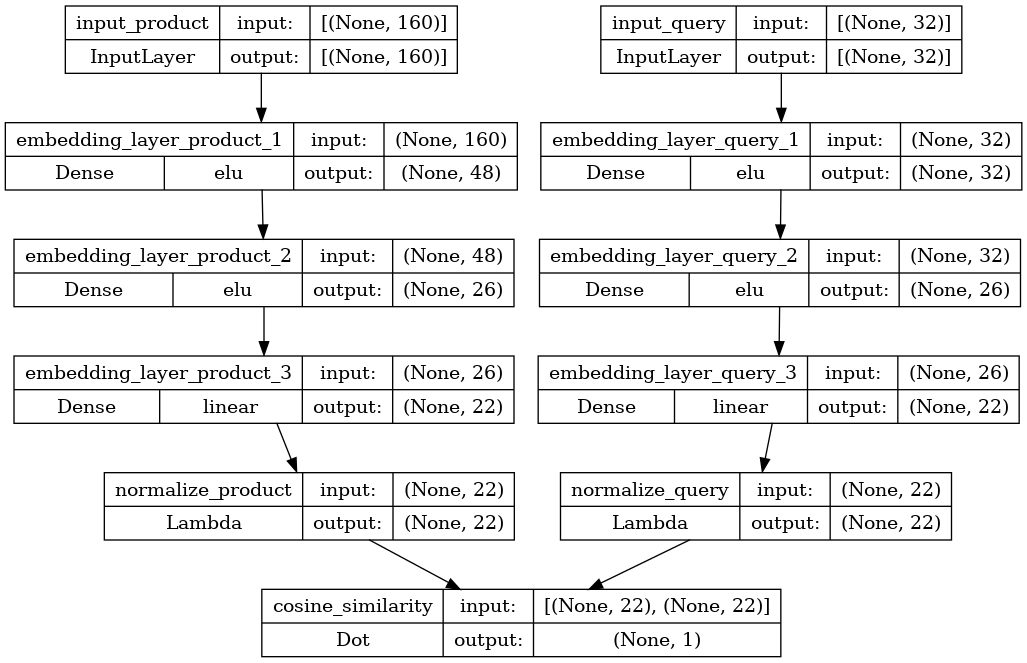

In [142]:
plot_model(model,show_shapes=1,show_layer_activations=1)

In [154]:
# Define a model checkpoint callback to save the best model weights during training
checkpoint_path = 'best_model_weights.h5' 
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',  
    verbose=1,
    save_best_only=True,  
    mode='min'  
)


model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])



history = model.fit(

    train_inputs, train_labels, epochs=30, batch_size=64, 
    validation_data=(val_inputs, val_labels),
    callbacks=[model_checkpoint],
    # Giving positive class more importance to positive labels to ensure precision is high.
    class_weight={0: 1, 1: 2} )


Epoch 1/30
2127/2138 [============================>.] - ETA: 0s - loss: 0.6808 - accuracy: 0.7362
Epoch 1: val_loss improved from inf to 0.47022, saving model to best_model_weights.h5
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6806 - accuracy: 0.7362 - val_loss: 0.4702 - val_accuracy: 0.8178
Epoch 2/30
2131/2138 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.7528
Epoch 2: val_loss improved from 0.47022 to 0.45415, saving model to best_model_weights.h5
2138/2138 [==============================] - 9s 4ms/step - loss: 0.6594 - accuracy: 0.7528 - val_loss: 0.4542 - val_accuracy: 0.8233
Epoch 3/30
2138/2138 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.7477
Epoch 3: val_loss did not improve from 0.45415
2138/2138 [==============================] - 9s 4ms/step - loss: 0.6699 - accuracy: 0.7477 - val_loss: 0.4767 - val_accuracy: 0.8171
Epoch 4/30
2134/2138 [============================>.] - ETA: 0s - loss: 0.6687 - ac

In [162]:
# After training, you can load the best model weights using:
model.load_weights(checkpoint_path)

<font style="font-size:18px;color:green;" >
Chop-off the product tower & generate/get product embeddings
</font>

In [163]:
product_model = Model(inputs=input_product,
                         outputs=model.get_layer('normalize_product').output
                   )

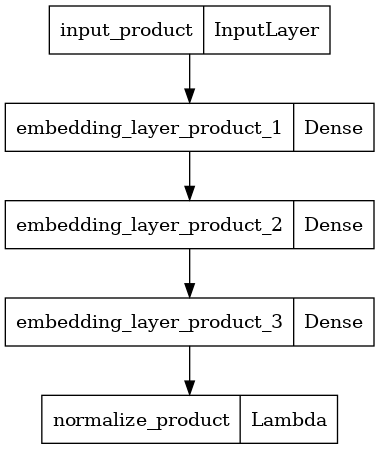

In [164]:
plot_model(product_model)

In [165]:

input_data_product = np.array(df_product_embedding[product_tower_cols])
product_embeddings = product_model.predict(input_data_product)
len(product_embeddings)

4615/4615 [==============================] - 5s 1ms/step


147673

In [166]:
df_product_embeddings_model = pd.DataFrame(product_embeddings, columns = [f'p{x}'for x in range(embedding_dim)] )

df_product_embeddings_model['product_id'] = df_product_embedding['product_id']
df_product_embeddings_model['product_title'] = df_product_embedding['product_title']
df_product_embeddings_model['pid'] = df_product_embedding['pid']

df_product_embeddings_model.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p15,p16,p17,p18,p19,p20,p21,product_id,product_title,pid
0,0.283781,-0.179713,-0.111249,-0.313161,0.197612,-0.299453,-0.289862,-0.135008,-0.055417,0.419509,...,0.073628,-0.221278,0.169323,0.270896,0.058389,-0.047754,-0.163398,B01A5DU2TA,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler",0
1,0.182527,-0.275141,0.023188,-0.315489,0.244938,-0.297384,-0.177439,-0.161835,-0.149632,0.393777,...,0.026619,-0.308903,0.338610,0.246397,-0.038189,-0.045726,-0.179171,B07346RPKN,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child",1
2,0.295139,-0.233910,-0.074741,-0.379686,0.179322,-0.198993,-0.291106,-0.249645,0.028223,0.284369,...,0.150167,-0.138828,0.017942,0.333666,-0.067504,-0.087224,-0.336735,B078TCVZ4V,Outee Rubber Kids Rain Boots,2
3,0.344942,-0.242364,-0.048095,-0.183980,0.038851,-0.218105,-0.300981,-0.120742,-0.159992,0.496944,...,0.063592,-0.151348,0.199331,0.048438,0.183667,-0.004361,-0.167601,B07BR3PPDR,Hope & Henry Girls' Red Milano Stitch Cardigan,3
4,0.067837,-0.208903,-0.020494,-0.307201,0.161889,-0.329115,-0.144966,-0.124764,-0.250371,0.449926,...,-0.041181,-0.291698,0.307342,0.222832,0.104715,-0.075996,-0.176551,B07H5C4P19,Spring&Gege Youth Solid Full Zipper Hoodies Soft Kids Hooded Sweatshirt for Boys and Girls Size 3-4 Years Red,4


<font style="font-size:18px;color:green" >
We can analyse the quality of learnt products embeddings of 22-dimensions by doing an ANN search/similarity search
</font>

In [167]:

pm = AnnoyIndex(embedding_dim, 'dot')
mp_product_dict = {}

for ix,row in df_product_embeddings_model.iterrows():
    mp_product_dict[int(row['pid'])] = row['product_title']
    
    key = int(row['pid'])
    vec = list(row[['p'+str(x) for x in list(range(embedding_dim))]])
    
#     print(key,vec)
    pm.add_item(key,vec)

In [168]:
pm.build(100) 
pm.save('product_model.tree')
pm = AnnoyIndex(embedding_dim,  'dot')
pm.load('product_model.tree')

True

In [169]:
top_k = 20
mat = []
for ix,row in df_product_embeddings_model.iterrows():
    item = row['product_title']
    mat.append([item] + [mp_product_dict[x] for x in pm.get_nns_by_item(row['pid'], top_k+1)[1:]])
    
    if ix == 50:
        break
    
cols = ['product_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors3 = pd.DataFrame(mat, columns = cols)

display(df_neighbors3.head(5))

['product_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,product_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,"Crocs Kids' Handle It Rain Boots , Candy Pink, 8 Toddler","UGG Unisex-Child Fluff Yeah Slide Slipper, Purple Rainbow, 8 Toddler US",Hoodie: Harry Potter- Slytherin Crest Pullover Hoodie Size L,"Crocs Kids' Handle It Rain Boots , Candy Pink, 12 Little Kid",Crazy Dog T-Shirts Mens Dadasaurus Tshirt Funny Fathers Day Dinosaur Tee for Guys (Dark Heather Grey) - XL,"Rubie's Costume Co. Studded Costume Gloves, Multicolor, One Size",johnnie-O Bunker PREP-Formance Striped Pique Polo,Retro Brooklyn Bums New York Baseball Ebbets Field Long Sleeve T-Shirt,Men Neckties Halloween Slytherin Tie For Women & Kids Stripe Cravat Polyester Green,Friday Shopping Crew Christmas Black Shopping Family Group T-Shirt,...,"EASTON DELUXE Baseball Pant, Youth, XSmall, Grey",Merica American Flag Aviators Toddler TShirt 4th July WHITE T-Shirt,"Crocs Kids' Classic Clog , Lavender, 3 Little Kid","Crocs Kids' Unicorn Clog, Ballerina Pink/New Mint, 2 Little Kid",This is Not a Drill T-Shirt Heather Red,"Socksmith Kahlo Portrait Socks Peacock Size 9-11, 1 EA",Sarcastic Comment Loading Novelty Graphic T Shirt L Dusk,"Crocs Kids' Handle It Rain Boots , Cerulean Blue, 10 Toddler",Fruit of the Loom Womens Built Up Tank Style Sports Bra,Coolest Guy on the Conference Call. Blue Q Men's Funny Crew Socks (fits shoe size 7-12)
1,"Hatley Kids' Little Classic Rain Boots, Pink & Navy, 8 US Child","The Children's Place boys Pull On Cargo Pants, Night Camo, 10","Spasilk Bath Hooded Terry Towels & Washcloths Set for Babies, Pink Butterfly, 4 Count",Brisco Brands Crawl Walk Fish Funny Fishing New Parents Gifts Cute Baby Onesie Bodysuit Navy 6 Months,Womens I'm Pregnant Not a Petting Zoo Tee Funny Pregnancy Shirts,"Jefferies Socks Baby Newborn Bubble Stitch Rock-a-bye Bootie 6 Pair Pack Socks, Pink/White, Newborn","Splash About, Go Splash, Chaleco de natación para niños, Azul (Vintage Moby), 1 - 2 años","Splash About Go Splash Swim Vest, Vintage Moby, 1-2 Years",Harry Potter Slytherin House Crest Pattern Men's Crew Socks 2 Pair Pack Shoe Size 6-12,"Littleforbig Adult Baby Diaper Lover (ABDL) Button Crotch Romper Onesie Pastel Series (XXL, Black/White)",...,"The Children's Place Boys' Denim Jacket, Streamwash, M (7/8)",Socksmith Puppy Prints Pink 9-11 (Women's Shoe Sizes 5-10.5),The Ashton - Drake Galleries Violet Parker Collectible Lifelike Weighted Baby Doll with Swaddle,"Goodthreads Men's 5-Pack Patterned Socks, Assorted Sea Life, One Size","Hudson Baby Unisex Cotton Rich Newborn and Terry Socks, Neutral Stripe, 6-12 Months","LittleForBig Adult Baby Onesie Diaper Lover (ABDL) Snap Crotch Romper Onesie Pajamas - I Love Daddy Pattern, Pink, Size MEDIUM","Columbia Baby Toddler Kids Double Trouble Jacket, Grape Gum/Grape Gum Reindeer, 4T","Hurley Men's One & Only Corp Flexfit Perma Curve Bill Baseball Hat, Khaki, L-XL","Goodthreads Men's 5-Pack Patterned Socks, Assorted Dogs, One Size","In Bloom by Jonquil Women's Zinnia, Sky Blue, L"
2,Outee Rubber Kids Rain Boots,Hawaiian Shirt 46 Mens Flower Leaf Beach Aloha Party Camp Holiday Red XL,"Good Luck Sock Men's Chess Socks, Adult",SPRAYGROUND BACKPACK MLB NY YANKEES SHARK,"Wild Bobby Straight Outta Minnesota MIN Fan | Fantasy Baseball Fans | Mens Sports Hooded Sweatshirt Graphic Hoodie, Navy, Small",MingDe Sports Spring Summer Beret Men Women's Newsboy Caps Octagonal Cap England Style Retro Flat Cap,Stetson Rawlins Pigskin Baseball Cap Men Grey One Size,Distressed Baseball Cap Vintage Dad Hat - Softball Mom (Black),Dabbing Pineapple Sunglasses Aloha Beaches Hawaii Hawaiian T-Shirt,Tommy Bahama Beach Umbrella 2020 Blue,...,"Koloa Surf Co. Colorful Tie-Dye T-Shirt, XL",Jumping Beans Little Boys' 4-12 Star Wars Trooper Tee 7 Charcoal Snow,"French Toast Boys' Big Pull-On Short, Navy, 10",Port & Company Knit Cap 20F,"Mohawk

In [170]:
gc.collect()

21467

<font style="font-size:18px;color:green;" >
Chop-off the query tower & generate/get query embeddings
</font>

In [171]:
query_model = Model(inputs=input_query,
                         outputs=model.get_layer('normalize_query').output
                   )

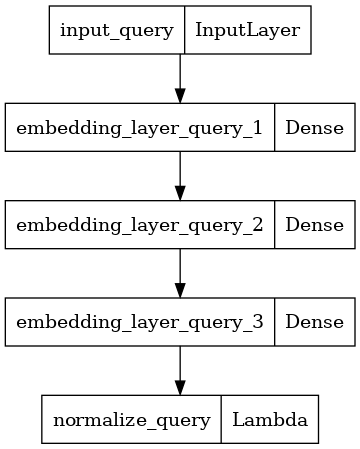

In [172]:
plot_model(query_model)

In [173]:
input_data_query = np.array(df_query_embedding[query_tower_cols])
query_embeddings = query_model.predict(input_data_query)
len(query_embeddings)

2212/2212 [==============================] - 3s 1ms/step


70756

In [174]:
df_query_embeddings_model = pd.DataFrame(query_embeddings, columns = [f'q{x}'for x in range(embedding_dim)] )

df_query_embeddings_model['query'] = df_query_embedding['query']
df_query_embeddings_model['qid'] = df_query_embedding['qid']

df_query_embeddings_model.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q14,q15,q16,q17,q18,q19,q20,q21,query,qid
0,-0.210550,0.197009,-0.260028,-0.085051,0.145512,-0.215475,0.148225,-0.021519,-0.029622,0.123713,...,0.125350,0.112450,-0.227201,0.259537,0.592127,-0.068164,-0.105003,0.094388,child proof cabinet locks,0
1,0.090467,-0.109474,-0.089486,-0.110296,-0.060808,-0.233766,-0.216790,-0.359021,-0.193314,0.322079,...,0.118384,0.161508,-0.380253,0.366617,0.254884,0.003704,-0.085017,-0.104309,ankle stockings for women sheer,1
2,0.047602,0.101648,-0.228609,-0.021010,0.132031,-0.079123,-0.285557,-0.241623,0.213920,0.050040,...,-0.187676,0.407535,-0.260191,0.065301,0.553552,-0.170738,0.089434,-0.039075,gluten free snacks,2
3,0.143955,0.004621,-0.268169,-0.074030,0.067412,-0.101362,-0.420032,-0.292630,0.019464,0.168806,...,-0.093430,0.296424,-0.335638,0.274998,0.312907,-0.082504,-0.056907,-0.024929,hair geow,3
4,0.124744,0.296613,-0.433919,0.132102,-0.216907,-0.147661,0.118742,-0.074466,0.002805,0.287147,...,-0.025793,0.340739,-0.062074,0.130485,0.491960,0.201208,-0.012967,0.058563,"1 by one, amplified, outdoor hdtv antenna",4


<font style="font-size:18px;color:green;" >
We can analyse the quality of learnt query embeddings of 22-dimensions by doing an ANN search/similarity search
</font>

In [175]:
from annoy import AnnoyIndex
# qm = AnnoyIndex(embedding_dim, 'euclidean')
qm = AnnoyIndex(embedding_dim, 'dot')
mp_query_dict = {}

for ix,row in df_query_embeddings_model.iterrows():
    mp_query_dict[row['qid']] = row['query']
    
    key = int(row['qid'])
    vec = list(row[['q'+str(x) for x in list(range(embedding_dim))]])

    qm.add_item(key,vec)

In [176]:
qm.build(100)
qm.save('query_model.tree')

# qm = AnnoyIndex(embedding_dim,  'euclidean')
qm = AnnoyIndex(embedding_dim,  'dot')
qm.load('query_model.tree')

True

In [177]:
top_k = 20
mat = []
for ix,row in df_query_embeddings_model.iterrows():
    item = row['query']
    mat.append([item] + [mp_query_dict[x] for x in qm.get_nns_by_item(row['qid'], top_k+1)[1:]])
    
    if ix == 50:
        break
    
cols = ['query_id']
for i in range(top_k):
    cols += ['nearest_{}'.format(i+1)]

print(cols)

df_neighbors4 = pd.DataFrame(mat, columns = cols)

display(df_neighbors4.head(50))

['query_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,query_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,child proof cabinet locks,child locks for cabinets,personalized toy box for boys,safety door latch for kids,buttons for crafts,float devices for kids,digger toys for boys,magnetic child safety cabinet locks,gardening tools starter kit,jeep trail doors,...,library kit,smart garden pods,kitchen gadget gifts,garden kits,cabinet handles,shower garden hose wand,portable door lock travel lock,door child lock,garden tool set,kids white board markers and eraser
1,ankle stockings for women sheer,womens riding boots,3/4 sleeve cardigan for women,sundresses for women casual summer,yellow tank top for women,funny graphic tees for men,knee high boots for women heel,knee high boots for women,off shoulder sweatshirt for women,womens winter nightgowns,...,womens learher skirt brown,oneil white short sleeve rash guard women,sequin tops for women,heel boots for women,workout shirts for women,steel toe work boots for men,elegant dresses with ruffles for women,womens tank tops,womens gloves with fur lining,shirt and cape women
2,gluten free snacks,sprinkles are for cupcakes not toilet seats,10ml roller bottle without roller ball,mint dog water,dry soup mix,chef knife with personalized box,wrinkle reducing cream,seasoning shaker,waterpik toothbrush,dr brown brush bottle cleaner,...,papaya enzymes chewable,contigo water bottle,cashews unsalted organic,coconut flavor mct creamer onnit brain food,toffee nut syrup,milk frother,sugar and sweetner holder,soy sauce packets,white chocolate peppermint bark,nature made fish oil capsules
3,hair geow,japonesque sponges,puma tshirt men,oopo reno 2,black head popper,shoeless joe ballgloves,sperry boots,sketchers golf shoes,inuyasha sweater,sperry duck boots women,...,pink earrinfs,winter oofos,pink tweezers,eyelash curler,hair bands men nike,orthofeet shoes,slogger boots 10,fuax mink eyelashes wispy,mypillow sheets,wig caps for women brown
4,"1 by one, amplified, outdoor hdtv antenna",led icicle lights blue,ring without alexa,dummy vga terminator,floral supplies for wedding,red hydrogen one,good enegry lights,multicolor lights,lighted jewelers magnifying glass,60 watt candelabra light bulbs led,...,dusk to daw. electric window candles,thoth tarot gold,h11 led fog bulb dual color,vanity mirror led lights,led under cabinet lighting,paracord key chain,12v blue led strip,gold cross charms,guitar ornament,sparklers candles
5,adidas sweats slim,adidas mens shoes,babybliss pro gold fx,adidas shoes women,adidas pants,toby keith greatest hits cd,adidas pants men,adidas shoes men,adidas shoes,adidas shoes pw hu,...,adidas tank top men,taylor swift perfume,american classics def leppard shirt,galaxy adidas shoes men,neck warmer adidas,metallica baby clothes,solange knowles vinyl,shorts adidas women,adidas pants women,adidas running shoes mens
6,beta sitosterol now,ez carafe,nail press on kiss,inis perfume,arizona state university pop socke,irestore professional,andies mints,citrisafe,black friday deals now,makeup mirror,...,vera bradley mimosa medallion,bodies are cool tyler feder,cvs scarf,dmall phollips screw driver,bona mega,paco rabanne 1 million,before we were yours by lisa wingate,marlowe soap,obagi clenziderm acne,lube
7,iphone 11 pro,clear phone case iphone xr,screen protector iphone x,charging phone case iphone xs,phone cases iphone 7,asus laptop charger ux305c,case for iphone 7,apple tv remote 2nd generation,phone case iphone x,iphone external storage,...,nexus 5x camera glass replacement,apple ipods,iphone 7 case lv,galaxy sm t580 tablet case,phone cases iphone 6s,fire hd 8 tablet case,apple battery case iphone 6s,iphone usb flash drive,case for iphone 6,phone cases for iphone 8
8,large training pads for dogs,electric dirt bike for kids 10 to 12,hebrew nationalhot dogs,square trampoline,10 exercise b

<font style="font-size:18px;color:green;" >
Random Queries generated from Chat-Gpt for an ecommerce website
</font>

In [178]:
product_search_queries = [
    "Red dress for a wedding",
    "Best laptop under $1000",
    "Nike running shoes for women",
    "iPhone 13 reviews",
    "Men's winter jackets on sale",
    "Top-rated kitchen appliances",
    "Summer dresses for women",
    "Samsung TV specifications",
    "Gift ideas for anniversary",
    "XYZ brand headphones",
    "Women's shoes size 8",
    "Deals on smartphones",
    "Men's formal suits",
    "Fitness trackers with heart rate monitor",
    "Digital cameras with 4K video",
    "Wireless gaming mouse",
    "Outdoor camping gear",
    "Bluetooth earbuds under $50",
    "Designer handbags on clearance",
    "Gaming laptops with RTX graphics",
    "Organic skincare products",
    "Smartphones with long battery life",
    "Running shoes for flat feet",
    "Laptop deals for students",
    "Wireless noise-canceling headphones",
    "Digital cameras for beginners",
    "Best coffee makers under $50",
    "Latest fashion trends for summer",
    "Top-rated gaming keyboards",
    "Dining room furniture sets",
    "Winter coats for kids",
    "Men's watches with leather straps",
    "Home gym equipment for small spaces",
    "Women's handbags on sale",
    "Bluetooth speakers with waterproof features",
    "Outdoor patio furniture",
    "Affordable fitness trackers",
    "Cookware sets for induction cooktops",
    "Portable chargers for smartphones",
    "Desktop computers for gaming",
]
product_search_queries

['Red dress for a wedding',
 'Best laptop under $1000',
 'Nike running shoes for women',
 'iPhone 13 reviews',
 "Men's winter jackets on sale",
 'Top-rated kitchen appliances',
 'Summer dresses for women',
 'Samsung TV specifications',
 'Gift ideas for anniversary',
 'XYZ brand headphones',
 "Women's shoes size 8",
 'Deals on smartphones',
 "Men's formal suits",
 'Fitness trackers with heart rate monitor',
 'Digital cameras with 4K video',
 'Wireless gaming mouse',
 'Outdoor camping gear',
 'Bluetooth earbuds under $50',
 'Designer handbags on clearance',
 'Gaming laptops with RTX graphics',
 'Organic skincare products',
 'Smartphones with long battery life',
 'Running shoes for flat feet',
 'Laptop deals for students',
 'Wireless noise-canceling headphones',
 'Digital cameras for beginners',
 'Best coffee makers under $50',
 'Latest fashion trends for summer',
 'Top-rated gaming keyboards',
 'Dining room furniture sets',
 'Winter coats for kids',
 "Men's watches with leather straps",


In [180]:
gc.collect()

724

In [181]:

# from laserembeddings import Laser
# # Load LASER model
# laser = Laser()

In [183]:
import numpy as np

def reshape_array(input_array, d):
    k, _ = input_array.shape
    new_array = np.zeros((k, d))
    
    for i in range(k):
        for j in range(d):
            start_idx = j * (768// d)
            end_idx = (j + 1) * (768// d) if j < (d - 1) else 768
            chunk = input_array[i, start_idx:end_idx]
            new_array[i, j] = np.mean(chunk)
    
    return new_array

In [184]:
# query_max_words = 10
# product_title_max_words = 50
# product_description_max_words = 20
# product_bullet_point_max_words = 50
# product_brand_max_words = 5
# product_color_max_words = 5

In [185]:
gc.collect()

0

In [186]:
from transformers import AutoTokenizer, AutoModel

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")



In [187]:
query_dim = 32

# Adjusting the length of query_tower_cols to match the expected number of columns
query_tower_cols = ['q' + str(x) for x in range(query_dim)]

# Assuming the rest of your code remains the same
sentences = product_search_queries
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Generate sentence embeddings
with torch.no_grad():
    output = model(**encoded_input)
sentence_embeddings = output.last_hidden_state[:, 0, :]

sentence_embeddings = reshape_array(np.array(sentence_embeddings), query_dim)
    
df_query_test_actual = pd.DataFrame(sentence_embeddings)
df_query_test_actual.columns = query_tower_cols
df_query_test_actual['query'] = product_search_queries

df_query_test_actual.head(10)


,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q23,q24,q25,q26,q27,q28,q29,q30,q31,query
0,-0.004835,-0.071944,0.060712,0.074942,-0.080056,-0.060664,0.052395,0.073022,0.143387,-0.030233,...,-0.007309,0.124466,0.051673,0.017317,-0.032823,-0.030152,0.035584,0.028431,-0.310722,Red dress for a wedding
1,-0.028991,-0.081145,0.076815,0.082736,-0.064117,-0.018063,0.059442,0.061062,0.112037,0.001484,...,0.003673,0.094573,-0.014011,0.019987,0.035323,-0.028354,0.036486,0.052302,-0.307154,Best laptop under $1000
2,-0.005726,-0.063729,0.032444,0.114587,-0.083815,-0.069721,0.048809,0.087556,0.136032,-0.040158,...,-0.013999,0.129115,0.041385,0.017655,-0.021334,-0.007328,0.077513,0.022514,-0.309256,Nike running shoes for women
3,-0.026968,-0.088771,0.061826,0.092333,-0.079053,-0.058392,0.066214,0.062310,0.138017,-0.023355,...,0.007534,0.125214,0.027374,0.032384,-0.004829,-0.005780,0.023703,0.018053,-0.348163,iPhone 13 reviews
4,-0.034703,-0.061277,0.055474,0.106849,-0.056597,-0.085907,0.041267,0.084270,0.167710,-0.020247,...,0.008637,0.110048,0.031231,0.009858,-0.035618,0.010900,0.026440,-0.010545,-0.323335,Men's winter jackets on sale
5,0.000909,-0.105722,0.080771,0.080087,-0.051089,-0.042167,0.053508,0.055480,0.112355,-0.037201,...,-0.010262,0.093161,0.042581,0.014840,-0.005548,-0.004033,-0.000394,0.026366,-0.276785,Top-rated kitchen appliances
6,-0.032266,-0.078885,0.065808,0.079998,-0.076183,-0.097623,0.061983,0.081811,0.156866,-0.021685,...,0.013177,0.129415,0.047573,0.013053,-0.044863,0.014212,0.019067,0.013661,-0.338032,Summer dresses for women
7,-0.033894,-0.090792,0.047921,0.084113,-0.080917,-0.027722,0.032838,0.042641,0.155645,-0.018143,...,-0.020375,0.127276,0.069241,0.026149,-0.026209,-0.025702,0.028603,0.075784,-0.339844,Samsung TV specifications
8,-0.021690,-0.090210,0.048648,0.034734,-0.092419,-0.087446,0.056366,0.007637,0.185745,-0.013352,...,0.035091,0.136111,0.055532,0.021309,0.005265,0.016034,0.007282,0.010896,-0.300497,Gift ideas for anniversary
9,0.005653,-0.095054,0.012797,0.073161,-0.073993,-0.049919,0.042836,0.042859,0.141472,-0.018268,...,0.016164,0.134527,0.034014,0.062870,-0.031605,-0.002561,0.032305,0.056959,-0.323698,XYZ brand headphones


In [189]:
sentence_embeddings

array([[-0.00483459, -0.07194433,  0.06071232, ...,  0.03558433,
         0.02843126, -0.31072211],
       [-0.02899113, -0.08114453,  0.07681518, ...,  0.03648592,
         0.05230227, -0.30715412],
       [-0.00572635, -0.06372935,  0.03244361, ...,  0.07751281,
         0.02251444, -0.30925581],
       ...,
       [-0.04042611, -0.0594932 ,  0.03726716, ...,  0.04590634,
         0.0104751 , -0.25411171],
       [-0.06293242, -0.12872849,  0.03453861, ...,  0.0479569 ,
         0.04451168, -0.34067225],
       [-0.08815634, -0.10318545,  0.05181283, ...,  0.0292035 ,
         0.03967029, -0.31957224]])

In [190]:
input_data_query = np.array(df_query_test_actual[query_tower_cols]),
query_embeddings = query_model.predict(input_data_query)
len(query_embeddings)

2/2 [==============================] - 0s 3ms/step


40

In [192]:
cols = [f'q{x}'for x in range(embedding_dim)]

df_query_test = pd.DataFrame(query_embeddings, columns = cols)
df_query_test['query'] = product_search_queries

df_query_test.head(50)

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q13,q14,q15,q16,q17,q18,q19,q20,q21,query
0,0.101846,-0.229391,-0.086018,-0.230704,0.325447,-0.114911,-0.252003,-0.114655,-0.086415,0.405476,...,0.155558,-0.125078,0.197971,-0.321428,0.293801,0.302033,0.025589,0.087514,-0.203237,Red dress for a wedding
1,0.143087,-0.192841,0.020895,-0.062248,0.198941,-0.207310,-0.292156,-0.209213,-0.031976,0.374334,...,0.073410,-0.239404,0.200753,-0.403098,0.336652,0.241207,-0.034508,0.150268,-0.046024,Best laptop under $1000
2,0.104235,-0.224947,-0.078235,-0.218173,0.289837,-0.110469,-0.344331,-0.152339,-0.106859,0.344463,...,0.179971,-0.111953,0.145460,-0.343761,0.317730,0.197639,-0.008221,0.030822,-0.145719,Nike running shoes for women
3,0.078410,-0.213683,0.004961,-0.168998,0.270499,-0.217588,-0.275013,-0.177836,-0.076848,0.395568,...,0.147000,-0.152689,0.139875,-0.398950,0.323268,0.272469,-0.015804,0.108902,-0.110809,iPhone 13 reviews
4,0.017178,-0.270483,0.018279,-0.287561,0.366008,-0.140358,-0.328777,-0.174854,-0.081653,0.261807,...,0.138974,-0.062185,0.087655,-0.374688,0.275925,0.247617,-0.117844,0.030734,-0.172388,Men's winter jackets on sale
5,0.081216,-0.157398,-0.093645,-0.161060,0.356237,-0.143607,-0.209909,-0.090687,0.016454,0.346298,...,0.075847,-0.208874,0.232366,-0.355963,0.309003,0.392363,-0.030335,0.124524,-0.108422,Top-rated kitchen appliances
6,0.075669,-0.269827,-0.033057,-0.266233,0.362466,-0.122150,-0.273156,-0.121245,-0.093937,0.360245,...,0.133071,-0.107431,0.144069,-0.334312,0.294645,0.271309,-0.037621,0.071403,-0.197125,Summer dresses for women
7,0.132777,-0.154337,-0.045300,-0.118846,0.264158,-0.239247,-0.249282,-0.119632,-0.023866,0.463685,...,0.161508,-0.262058,0.162028,-0.354533,0.279549,0.301466,0.046742,0.157915,-0.064642,Samsung TV specifications
8,0.059906,-0.180509,-0.114346,-0.251579,0.394747,-0.149172,-0.094437,-0.060484,-0.020068,0.358269,...,0.124542,-0.095119,0.199241,-0.312042,0.301791,0.444956,-0.030205,0.078600,-0.190596,Gift ideas for anniversary
9,0.097339,-0.109570,-0.117798,-0.090978,0.258051,-0.189704,-0.257090,-0.099982,-0.037350,0.440711,...,0.123695,-0.248474,0.209771,-0.358270,0.320415,0.326431,0.061156,0.145512,-0.041812,XYZ brand headphones


In [193]:
results = []
top_k = 20

desc = []
for i in range(top_k):
    desc.append(f'product_title_{(i+1)}')
desc = ['query'] + desc

for ix,row in df_query_test.iterrows():
    qvec = [f'q{x}' for x in list(range(embedding_dim))]
    qvec = row[qvec]
    similar_vector_ids,similar_distances = pm.get_nns_by_vector(qvec, top_k, include_distances=True)
    similar_vector_product_title = [mp_product_dict[x] for x in similar_vector_ids]
    results.append([row['query']] + similar_vector_product_title)

df_results = pd.DataFrame(results, columns =  desc)

df_results.head(50)

,query,product_title_1,product_title_2,product_title_3,product_title_4,product_title_5,product_title_6,product_title_7,product_title_8,product_title_9,...,product_title_11,product_title_12,product_title_13,product_title_14,product_title_15,product_title_16,product_title_17,product_title_18,product_title_19,product_title_20
0,Red dress for a wedding,Crochet Boutique: Hats: 25 Fresh Takes on Classic Crocheted Hat Designs,Tipsy Elves Women's Cute Sequined Snowflake Leggings for Christmas: XL,Baby Girls Boys Winter Hat Scarf Earflap Hood Scarves Skull Caps Coffee One Size,Vintage Fly Mens Ugly Christmas Sweater Merry Christmas You Filthy Animal Pullover Sweatshirt,AILIBOTE Lilo & Stitch BE You and ownif Holiday of The Year Hoodie Sweater for Womens Black XL,"Parker Baby Bandana Drool Bibs 8 Pack Baby Bibs for Boys, Girls, Unisex - ""Lunar Set""","Bazzle Baby BandoBib Infinity Scarf Bib, Double-Layer Cotton & Fleece, 3 to 24 Months, 2-Pk",Snap Jewelry Rhinestone Starfish In Ocean fits 18-20mm Standard Size Ginger Style Charms My Prime Gifts,Tipsy Elves Men's Ugly Christmas Sweater - Happy Birthday Jesus Sweater Green Size L,...,"Zarbee's Naturals Children's Sleep with Melatonin Gummy Supplement, Berry Gummies 80 Count (Pack of 1)",New Ea Knit Hat NFL Seattle Seahawks Sideline Sport Knit Winter Beanie Pom Hat Cap,This Is My Christmas Pajama Shirt Funny Christmas T Shirts,inktastic Christmas Cat-Puccino in Baby T-Shirt 24 Months Vintage Natural 382ef,"Hudson Baby Unisex Cotton Rich Newborn and Terry Socks, Neutral Stripe, 6-12 Months","Queen Bee | Funny, Cute, Cool Boss Lady Crown Alpha Top Baseball Hat Women Cap-Black","Tommy Bahama Bananas for You 100% Cotton-Comforter Set, Queen, Green",We Tested Positive But Not for Corona Pregnancy Baby Announcement Shirt Black,Men's Ask Your Mom If I'm Real Ugly Christmas Sweater - Funny Santa Sweater: X-Large,San Francisco Baseball Vintage SF Pride The City Gift T-Shirt
1,Best laptop under $1000,"The Honest Company - Super Club Box, Clean Conscious Diapers, Rose Blossom + Tutu Cute, Size 1, 160 Count (Packaging May Vary)","The Honest Company - Super Club Box, Clean Conscious Diapers, Rainbow Stripes + Flower Power, Size 3, 136 Count (Packaging May Vary)","DiaperPax Diaper Variety Sampler Set, 7 Styles to Try, Pick Your Size (Newborn)","Burt's Bees Baby Shampoo & Wash, Tear Free Soap, Natural Baby Care, Original, 12 Ounce (Pack of 3)","DiaperPax Diaper Variety Sampler Set, 7 Styles to Try, Pick Your Size (Size 1)",Big Joe XXL Denim Lenox Black Fuf Removable Foam Filled Bean Bag Covers,"Munchkin Arm & Hammer Diaper Pail Snap, Seal and Toss Refill Bags, 900 Count, 30 Pack",La Calla Women’s Bath Wrap - %100 Terry Cotton - Turkish Spa Shower Women Wraps with Adjustable Closure (White),"Amazon Brand - Solimo Extra Comfort Mint Dental Floss, 40 M (Pack of 6)",...,COTTON CRAFT Ultra Soft 4 Pack Oversized Large Bath Towels 30x54 - Highly Absorbent Bathroom Shower Towels - Ideal for Everyday Use - Easy Care Machine Wash - Premium Ringspun Cotton 580 GSM - Linen,Babyfeel Refills Compatible with Dekor Plus Diaper Pail | 8 Pack | Exclusive 30% Extra Thickness | Diaper Pail Refills with Powerful Odor Elimination | Fresh Powder Scent | Holds up to 4640 Diapers,"Playtex Baby Diaper Genie Refill Bags, Fresh, 270 Count, Pack of 3","Melissa & Doug Make-a-Face Sticker Pad - Fashion Faces, 20 Faces, 5 Sticker Sheets","Grandma's Secret wr Wrinkle Remover Spray, 16 oz-2 Pack",The Year Without a Santa Claus Hot Head T-Shirt,The Macbeth Collection Self Adhesive Shelf Liner - 2 Pack - Rugby Chevron Graphite,"Hudson Baby baby girls Cotton Coverall, Strawberry Lemon, 6-9 Months US","ChapStick S'mores Collection Graham Cracker, Marshmallow and Milk Chocolate Flavored Lip Balm Tubes Variety Pack, Lip Care - 0.15 Oz (Pack of 3)","Diapers Size 3, 136 Count - Pampers Swaddlers Disposable Baby Diapers, Enormous Pack (Packaging May Vary)"
2,Nike running shoes for women,AILIBOTE Lilo & Stitch BE You and ownif Holiday of The Year